In [115]:
import json
import re
import pandas as pd
import seaborn as sns
from collections import Counter, defaultdict
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import stanza
from pathlib import Path

In [116]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stanza.download('en')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/raquelpanadero/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/raquelpanadero/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raquelpanadero/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2024-10-22 12:40:28 INFO: Downloaded file to /home/raquelpanadero/stanza_resources/resources.json
2024-10-22 12:40:28 INFO: Downloading default packages for language: en (English) ...
2024-10-22 12:40:30 INFO: File exists: /home/raquelpanadero/stanza_resources/en/default.zip
2024-10-22 12:40:34 INFO: Finished downloading models and saved to /home/raquelpanadero/stanza_resources


In [91]:
# Get the current file's directory and project root
CURRENT_DIR = Path().absolute()
PROJECT_ROOT = CURRENT_DIR.parent
ANNOTATION_FILE_PATH = PROJECT_ROOT / 'data' / 'EN' / 'subtask-2-annotations.txt' # we work only in English for now
DATA_PATH = PROJECT_ROOT / 'data' / 'EN' / 'raw-documents'

## Most frequent words

In [121]:
class WordFrequencyAnalyzer:
    def __init__(self):          
        # Get stopwords from NLTK and Stanza
        self.nltk_stopwords = set(stopwords.words('english'))
        
        # Additional common words to filter
        self.additional_stopwords = {
            'said', 'would', 'could', 'also', 'one', 'two', 'three',
            'first', 'second', 'third', 'new', 'time', 'year', 'years',
            'many', 'much', 'may', 'might', 'must', 'like', 'well'
        }
        
        self.all_stopwords = self.nltk_stopwords.union(self.additional_stopwords)

    def process_file(self, file_path):
        """Process a single file and return word frequencies with and without stopwords."""
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read().lower()  # Convert to lowercase
            
            # NLTK tokenization
            tokens = word_tokenize(text)
            
            # Remove punctuation and numbers
            words = [word for word in tokens if word.isalpha()]
            
            # Create two frequency distributions
            freq_with_stops = Counter(words)
            freq_without_stops = Counter(
                word for word in words if word not in self.all_stopwords
            )
            
            return {
                'with_stops': freq_with_stops,
                'without_stops': freq_without_stops,
                'total_words': len(words)
            }
            
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            return None

    def analyze_directory(self, data_dir: str):
        """Analyze all text files in the directory."""
        data_path = Path(data_dir)
        if not data_path.exists():
            raise FileNotFoundError(f"Directory not found: {data_path}")

        # Initialize counters for different file types
        cc_frequencies = {'with_stops': Counter(), 'without_stops': Counter()}
        ua_frequencies = {'with_stops': Counter(), 'without_stops': Counter()}
        
        # Statistics
        stats = {
            'CC': {'files': 0, 'total_words': 0},
            'UA': {'files': 0, 'total_words': 0}
        }

        # Process each file
        for file_path in data_path.glob('*.txt'):
            results = self.process_file(file_path)
            if results:
                # Determine file type
                filename = file_path.name
                if 'CC' in filename:
                    file_type = 'CC'
                    target_freq = cc_frequencies
                elif 'UA' in filename:
                    file_type = 'UA'
                    target_freq = ua_frequencies
                else:
                    continue  # Skip files that don't match either pattern

                # Update statistics
                stats[file_type]['files'] += 1
                stats[file_type]['total_words'] += results['total_words']
                
                # Update frequencies
                target_freq['with_stops'].update(results['with_stops'])
                target_freq['without_stops'].update(results['without_stops'])

        # Create DataFrames for top 20 words
        def create_freq_df(counter: Counter, label: str):
            df = pd.DataFrame.from_records(
                counter.most_common(20),
                columns=['word', 'frequency']
            )
            df['source'] = label
            return df

        # Create separate DataFrames for CC and UA
        cc_with_stops = create_freq_df(cc_frequencies['with_stops'], 'Climate Change')
        cc_without_stops = create_freq_df(cc_frequencies['without_stops'], 'Climate Change')
        ua_with_stops = create_freq_df(ua_frequencies['with_stops'], 'Ukraine-Russia War')
        ua_without_stops = create_freq_df(ua_frequencies['without_stops'], 'Ukraine-Russia War')

        # Combine DataFrames
        with_stops_df = pd.concat([cc_with_stops, ua_with_stops])
        without_stops_df = pd.concat([cc_without_stops, ua_without_stops])

        return stats, with_stops_df, without_stops_df

    def plot_comparisons(self, with_stops_df: pd.DataFrame, without_stops_df: pd.DataFrame):
        """Create comparison plots for word frequencies."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

        # Plot frequencies with stopwords
        sns.barplot(data=with_stops_df, x='frequency', y='word', hue='source', ax=ax1)
        ax1.set_title('Top 20 Words (Including Stopwords)')
        ax1.set_xlabel('Frequency')
        ax1.set_ylabel('Word')

        # Plot frequencies without stopwords
        sns.barplot(data=without_stops_df, x='frequency', y='word', hue='source', ax=ax2)
        ax2.set_title('Top 20 Words (Excluding Stopwords)')
        ax2.set_xlabel('Frequency')
        ax2.set_ylabel('Word')

        plt.tight_layout()
        plt.show()


File Statistics:

CC Files:
Number of files: 72
Total words processed: 32,996

UA Files:
Number of files: 128
Total words processed: 65,152


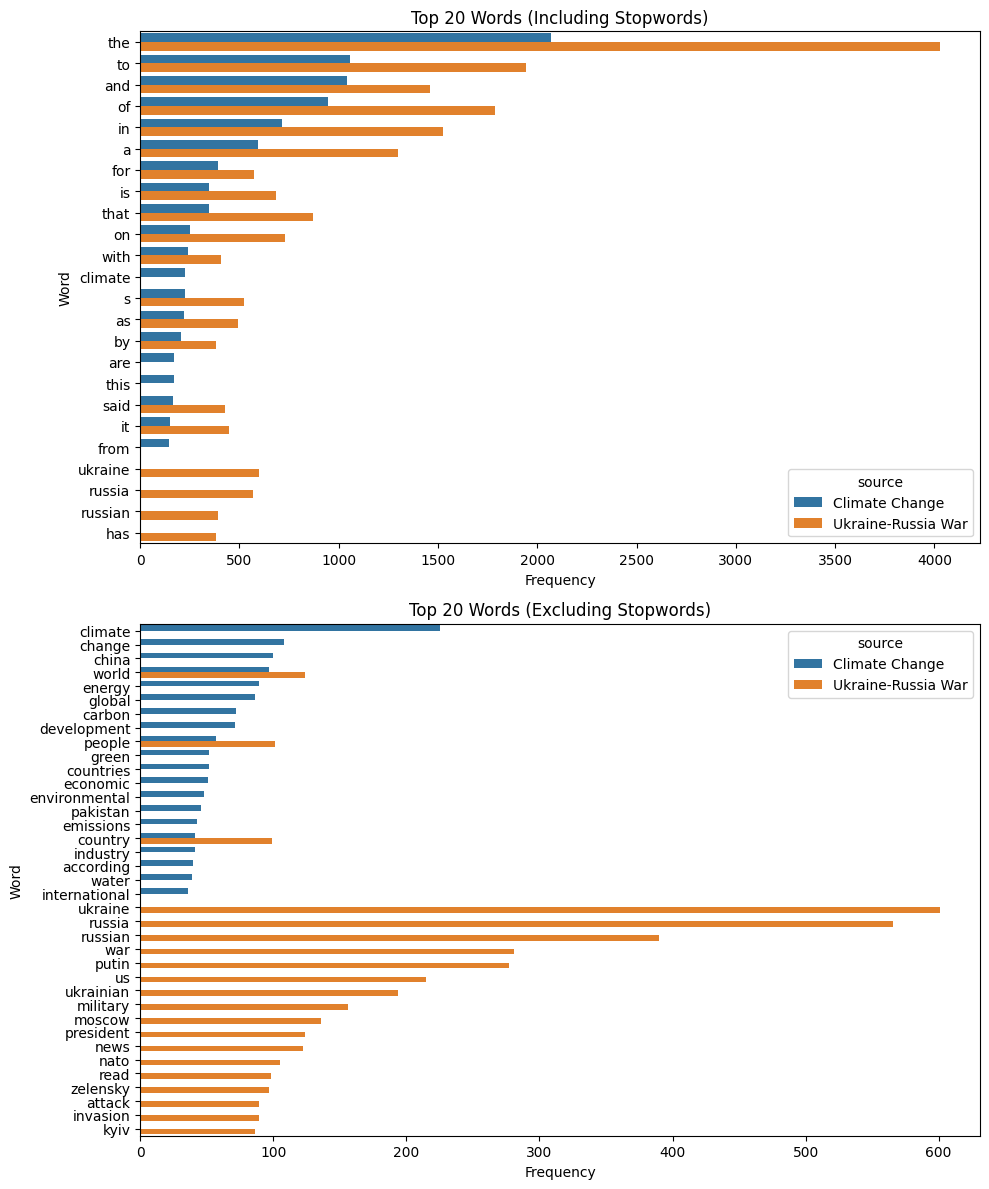

In [122]:
analyzer = WordFrequencyAnalyzer()
data_dir = "data"  # Adjust path as needed
stats, with_stops_df, without_stops_df = analyzer.analyze_directory(DATA_PATH)

# Print statistics
print("\nFile Statistics:")
for file_type, file_stats in stats.items():
    print(f"\n{file_type} Files:")
    print(f"Number of files: {file_stats['files']}")
    print(f"Total words processed: {file_stats['total_words']:,}")

# Create visualizations
analyzer.plot_comparisons(with_stops_df, without_stops_df)

## Irrelevant words to remove

In [101]:
class BoilerplateAnalyzer:
    def __init__(self):
        # Common boilerplate patterns to search for
        self.boilerplate_patterns = {
            'read_more': r'read more|most read|read all the',
            'subscribe': r'subscribe',
            'sign_up': r'sign up',
            'follow_us': r'follow us',
            'click_here': r'click here',
            'share': r'share this',
            'advertisement': r'advertisement',
            'more_info': r'for more information',
            'download_app': r'download our app',
            'related': r'related articles',
            'read_time': r'\d+ min read',
            'publish_date': r'published on',
            'copyright': r'copyright',
            'rights': r'all rights reserved',
            'watch_video': r'watch this video',
            'watch_more': r'watch more',
            'find out more': r'find out more',
            'social_media': r'twitter|instagram|facebook|telegram',
            '@': r'@',
            'news_company': r'(?: [A-Z][a-z]+)+ News',
            'according_to': r'according to'
        }
        
        # Compile patterns for efficiency
        self.compiled_patterns = {
            name: re.compile(pattern, re.IGNORECASE) if '[A-Z]' not in pattern else re.compile(pattern)
            for name, pattern in self.boilerplate_patterns.items()
        }

    def analyze_file(self, file_path: Path):
        """Analyze a single file for boilerplate patterns."""
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()

            results = {
                'filename': file_path.name,
                'total_lines': len(content.splitlines()),
                'total_chars': len(content),
                'matches': defaultdict(list)
            }

            # Find all matches for each pattern
            for name, pattern in self.compiled_patterns.items():
                matches = pattern.finditer(content)
                for match in matches:
                    results['matches'][name].append({
                        'text': match.group().strip(),
                        'position': match.start()
                    })

            return results
        
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            return None

    def analyze_directory(self, data_dir: str):
        """Analyze all text files in the directory."""
        data_path = Path(data_dir)
        if not data_path.exists():
            raise FileNotFoundError(f"Directory not found: {data_path}")

        all_results = []
        total_stats = defaultdict(int)
        pattern_locations = defaultdict(list)
        
        # Process each file
        for file_path in data_path.glob('*.txt'):
            results = self.analyze_file(file_path)
            if results:
                all_results.append(results)
                
                # Update total statistics
                total_stats['total_files'] += 1
                total_stats['total_lines'] += results['total_lines']
                total_stats['total_chars'] += results['total_chars']
                
                # Count pattern matches
                for pattern_name, matches in results['matches'].items():
                    total_stats[f'{pattern_name}_count'] += len(matches)
                    for match in matches:
                        pattern_locations[pattern_name].append(
                            match['position'] / results['total_chars']  # Normalize position
                    )
        
        # Create summary DataFrame
        summary_data = []
        for pattern_name in self.boilerplate_patterns.keys():
            count = total_stats.get(f'{pattern_name}_count', 0)
            avg_position = (
                sum(pattern_locations[pattern_name]) / len(pattern_locations[pattern_name])
                if pattern_locations[pattern_name] else 0
            )
            
            summary_data.append({
                'pattern': pattern_name,
                'total_occurrences': count,
                'files_percentage': (count / total_stats['total_files'] * 100) if total_stats['total_files'] > 0 else 0,
                'avg_relative_position': avg_position
            })

        summary_df = pd.DataFrame(summary_data)
        summary_df = summary_df.sort_values('total_occurrences', ascending=False)

        return summary_df, total_stats

    def plot_statistics(self, summary_df, total_stats):
        """Plot analysis results."""
        plt.figure(figsize=(8, 5))
        plt.barh(summary_df['pattern'], summary_df['files_percentage'])
        plt.title('Percentage of Files Containing Each Boilerplate Pattern')
        plt.xlabel('Percentage of Files (%)')
        plt.ylabel('Pattern Type')
        plt.tight_layout()
        plt.show()
        


Overall Statistics:
Total files analyzed: 200
Total lines processed: 6,961
Total characters processed: 631,377

Boilerplate Pattern Summary:


,pattern,total_occurrences,files_percentage,avg_relative_position
20,according_to,110,55.0,0.461818
17,social_media,105,52.5,0.669872
0,read_more,86,43.0,0.650746
19,news_company,68,34.0,0.736194
18,@,49,24.5,0.656091
1,subscribe,15,7.5,0.614771
3,follow_us,11,5.5,0.983755
4,click_here,8,4.0,0.580048
2,sign_up,4,2.0,0.265765
5,share,3,1.5,0.949665


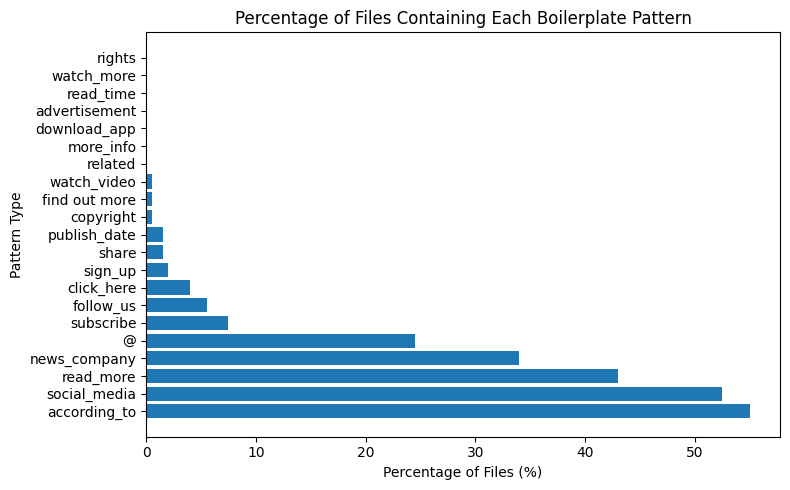

In [102]:
analyzer = BoilerplateAnalyzer()
data_dir = "data"  # Adjust path as needed
summary_df, total_stats = analyzer.analyze_directory(DATA_PATH)

# Print statistics
print("\nOverall Statistics:")
print(f"Total files analyzed: {total_stats['total_files']}")
print(f"Total lines processed: {total_stats['total_lines']:,}")
print(f"Total characters processed: {total_stats['total_chars']:,}")

# Display summary DataFrame
print("\nBoilerplate Pattern Summary:")
display(summary_df)

# Plot results
analyzer.plot_statistics(summary_df, total_stats)

In [103]:
def search_text(pattern, r=20):
    for file_path in DATA_PATH.glob('*.txt'):
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        if '[A-Z]' in pattern:   
            match = re.search(pattern, text)
        else:
            match = re.search(pattern, text, re.IGNORECASE)
        if match is None:
            continue
        i, j = match.span()
        start = max(i-r, 0)
        end = j+r
        print(f"{file_path.name}...{text[start:end]}...\n\n")

In [104]:
search_text(r'(?: [A-Z][a-z]+)+ News')

EN_UA_025165.txt...e US politician told Fox News that he planned to ...


EN_UA_023816.txt...
By Magyar Nemzet of Remix News

A Russian general ...


EN_CC_100008.txt...rding to a report by Fox News.

“Reports coming i...


EN_UA_102958.txt...r," Mr Bondarev told Sky News.

"You should have ...


EN_UA_022319.txt...Sea.

Mr. Sunak told Sky News, “As we’ve said, no...


EN_CC_200022.txt...

 by Frank Bergman, Slay News:

The Danish govern...


EN_UA_015443.txt...ncies.

Read all the Latest News , Trending News , C...


EN_UA_023211.txt...son for interview 

 Former Fox News star Carlson releas...


EN_CC_100093.txt...sery and suffering.— Rebel News (@RebelNewsOnline) ...


EN_UA_014014.txt...encies

Read all the Latest News , Trending News , C...


EN_UA_024050.txt...icle by John Cody at Remix News shows that the Germ...


EN_CC_100159.txt...te with more news on Trend News Agency's WhatsApp c...


EN_CC_100047.txt...ign something,” said Fox News host Bill Hammer.

...


EN_UA_010095.txt